<div style="text-align: center;">
    <img src="Silicone logo-1.jpg" style="width: 60%; height: auto;">
</div>

# **Implementation of NR-HIE Framework: Bridging the Generalizability Gap in Diabetes Prediction**

**Project Title:** Bridging the Generalizability in Diabetes Prediction: A Noise-Resilient-Hybrid-Imputation-Ensemble (NR-HIE) Framework for Robust Clinical Decision Support  
**Framework:** Noise-Resilient Hybrid Imputation–Ensemble (NR-HIE)  
**Author:** Hasnain Alam | **Supervisor:** Hafizuddin  
**Department:** Artificial Intelligence and Data Science  
**Organization:** Silicone Global Tech Gilgit Baltistan  

# Project Introduction & Motivation


### **The Generalizability Gap**
Machine learning models designed for diabetes prediction often demonstrate high performance on controlled academic datasets but experience a significant drop in efficiency when deployed in real-world clinical settings. This phenomenon, known as the **Generalizability Gap**, is fundamentally driven by factors such as:
* **Data Heterogeneity:** Variations in patient demographics and clinical protocols.
* **Non-Random Missingness (MNAR):** Missing data patterns that carry clinical significance (e.g., unrecorded insulin levels).
* **Imputation Bias:** Errors introduced by relying on single imputation methods.

### **The Proposed Solution: NR-HIE Framework**
To mitigate these issues, this notebook implements the **Noise Resilient Hybrid Imputation–Ensemble (NR-HIE) Framework**. This architecture addresses imputation bias through a parallel processing approach:

1.  **Hybrid Imputation Streams:**
    * *MICE (Multiple Imputation by Chained Equations):* Handles complex feature dependencies.
    * *KNN (K-Nearest Neighbors):* Preserves local data structures.
    * *Robust/Constant Imputation:* Provides noise resilience against outliers.
2.  **Feature Space Concatenation:** Merging outputs from all streams to preserve maximal information.
3.  **Ensemble Learning:** Utilizing diverse base learners (Logistic Regression, Random Forest, XGBoost).
4.  **Stacked Generalization:** A meta-learning strategy to synthesize final predictions for cross-dataset stability.

### **Project Objectives**
* **Objective 1:** Implement a parallel architecture to mitigate imputation bias.
* **Objective 2:** Address data noise and outliers through robust statistical scaling.
* **Objective 3:** Utilize Stacked Generalization to enhance cross-dataset stability.
* **Objective 4:** Incorporate Explainable AI (SHAP) to build clinical trust.

---

### **Notebook Contents**
* **Step 1:** Environment Setup & Library Import
* **Step 2:** Data Loading & Exploratory Data Analysis (EDA)
* **Step 3:** Data Preprocessing
* **Step 4:** Noise-Resilient Hybrid Imputation (MICE, KNN, Robust)
* **Step 5:** Feature Concatenation & Engineering
* **Step 6:** Ensemble Model Training (Base Learners)
* **Step 7:** Stacked Generalization & Final Prediction
* **Step 8:** External Validation (Generalizability Test)
* **Step 9:** Explainable AI (XAI) with SHAP
* **Step 10:** Conclusion & Future Work

---

# IMPORT NECESSARY LIBRARIES

Import the essential libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and the specific machine learning components required for the NR-HIE framework (Scikit-Learn, XGBoost).

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score , confusion_matrix, roc_curve , auc , roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import brier_score_loss
from scipy.stats import wilcoxon
import shap
import joblib
import os

import warnings
warnings.filterwarnings('ignore')


# DATA LOADING AND INITIAL EXPLORATORY DATA ANALYSIS (EDA)

## Load Dataset
The Pima Indians Diabetes Dataset utilized as our primary benchmark. This dataset is known for having "hidden" missing values (encoded as 0) in clinically impossible fields like Glucose and BMI, making it an ideal candidate for testing the **Non-Random Missingness (MNAR)** capabilities of the NR-HIE framework.

## Initial Inspection
* **Shape & Structure:** Understanding the dimensionality of the data.
* **Statistical Summary:** Analyzing the central tendency and dispersion to detect anomalies.
* **Missing Value Analysis:** Identifying the "0" placeholders that require advanced imputation strategies.

In [2]:
df = pd.read_csv('E:\Data Science Course Content\Machine learning project\Raw\Pima_Dibetes_Data.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# To get initial summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Statistical Summary
Generate descriptive statistics to observe the distribution of features. High standard deviations or min values of "0" in columns like `Glucose`, `BloodPressure`, or `BMI` indicate data quality issues that our Hybrid Imputation stream will need to resolve.

In [4]:
# To check statistical Summary
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Checking Missing Values
Checked for missing values 

In [5]:
# To check missing values
missing = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing)
print(missing_percent)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64


###  MNAR Detection (Missing Not At Random)
In this dataset, missing values are not encoded as `NaN` but as `0`. A value of 0 for `SkinThickness`, `Insulin`, or `BMI` is biologically impossible. 

These zero-values to determine the extent of the imputation task required for the MICE, KNN, and Robust imputation streams.

In [6]:
# Check columns with zeroes
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("\nCounts of 0 in coloumns:")
print((df[columns_with_zeros] == 0).sum())


Counts of 0 in coloumns:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


### ANALYSIS OF NON-RANDOM MISSINGNESS (MNAR)

### The "Hidden" Null Values
As observed in the counts above, features such as `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` contain values of `0`. In a clinical setting, a skin thickness or insulin level of 0 is biologically impossible for a living patient. These are **Missing Values encoded as zeros**.

### Why this is "Missing Not At Random" (MNAR)
Unlike random data loss (MCAR), these missing values often carry structural meaning:
* **Insulin tests** are expensive and painful; they are often skipped if the patient does not show specific symptoms.

### Connection to NR-HIE Framework
Standard imputation (like Mean or Median filling) assumes data is missing at random. Applying simple imputation here would introduce **Imputation Bias**, distoring the real clinical relationships. 

**This specific data characteristic justifies the "Hybrid" component of our proposed framework:**
1.  **MICE Stream:** Will use correlations between *Age* and *BMI* to estimate missing *Insulin* levels (modeling the dependency).
2.  **KNN Stream:** Will find patients with similar physical profiles to fill gaps based on local structure.
3.  **Robust Stream:** Will prevent outliers in `Insulin` from skewing the imputation of `Glucose`.

# Visualizations of Columns with Zeros

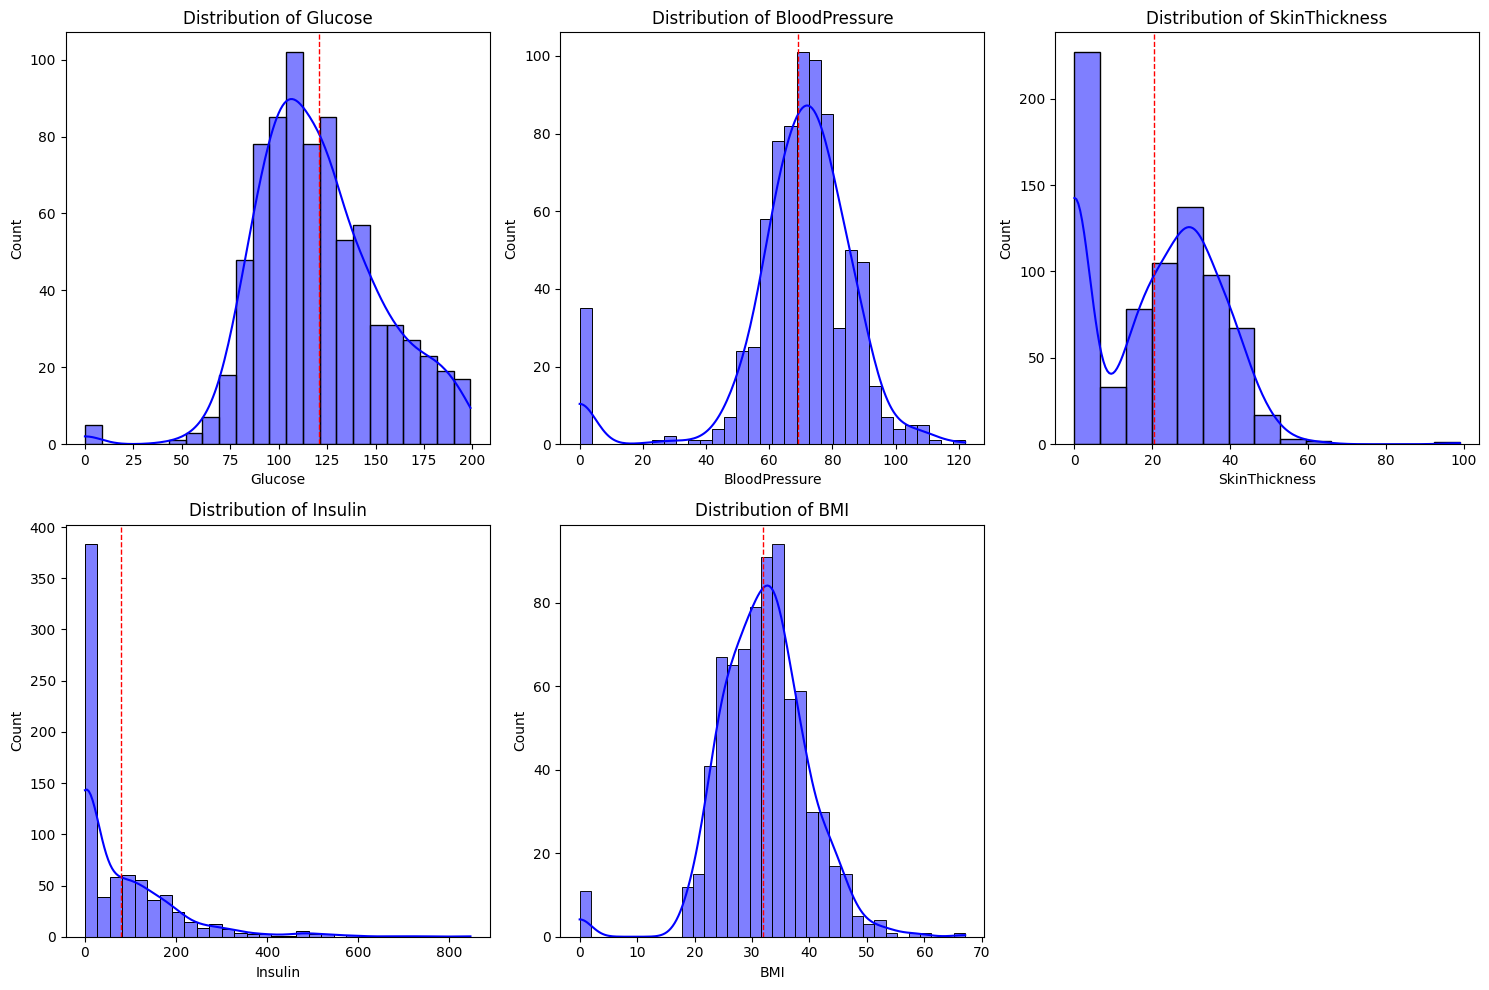

In [7]:
# Visualizations of coulumns with zeroes 

cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

plt.figure(figsize=(15, 10))

for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1) 
    sns.histplot(df[col], kde=True, color='blue') # Histogram with Kernel Density Estimate
    plt.title(f'Distribution of {col}')
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean') # Mean line

plt.tight_layout()
plt.show()

# UNIVARIATE ANALYSIS & NOISE DETECTION

### Visualization: Feature Distribution Histograms
**Why we created this:**
To determine the "Heterogeneity" of the patient population. We look for Gaussian (Normal) distributions versus Skewed distributions to select the correct Base Learners for our Ensemble.

**What this is showing:**
1.  **Skewed Data (Insulin, BMI, SkinThickness):** These features have a "long tail" to the right. 
    * *Implication:* Linear Regression (a base learner in our ensemble) struggles here. This justifies including **Non-Parametric models like Random Forest and XGBoost** in the NR-HIE ensemble, as they handle skewness automatically.
2.  **Gaussian-like Data (Glucose, BloodPressure):** These approximate a Bell curve.
    * *Implication:* These features stabilize the ensemble, allowing the Logistic Regression component to perform effectively.

# BIVARIATE ANALYSIS (RELATIONSHIPS)

### Visualization: Correlation Heatmap
**Why we created this:**
To map the "Complex Dependencies" mentioned in the proposal. MICE (Multiple Imputation by Chained Equations) works by using the correlation of $X$ to predict $Y$. If no correlation exists, MICE fails.

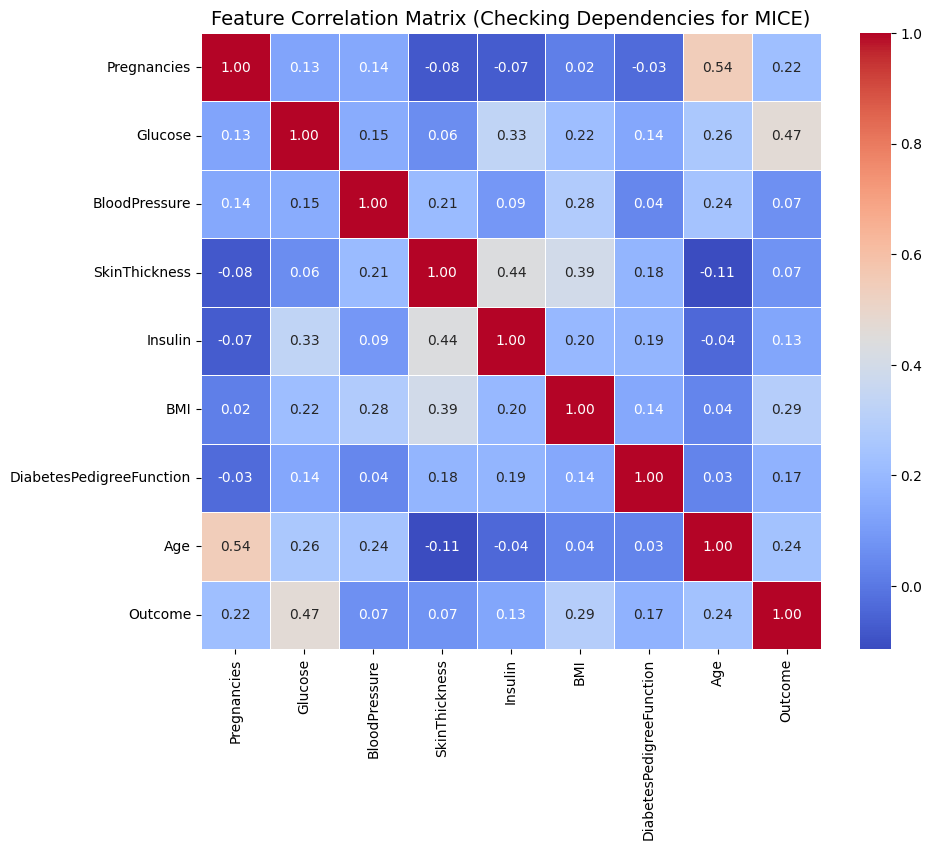

In [8]:
# Correlation matrix

plt.figure(figsize=(10, 8))
corr_matrix = df.corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix (Checking Dependencies for MICE)', fontsize=14)
plt.show()


**What this is showing:**
* **Age vs. Pregnancies:** Strong positive correlation.
* **Glucose vs. Outcome:** Strong positive correlation (indicating Glucose is a strong predictor of Diabetes).
* **SkinThickness vs. BMI:** Moderate correlation.

**Framework Validation:**
The existence of these inter-feature correlations confirms that **Multivariate Imputation (MICE)** is the mathematically correct approach for the first stream of the NR-HIE framework, as opposed to simple univariate imputation.

### Visualization: Outlier Detection (Box Plots)
**Why we created this:**
To identify "Noisy" data points that could degrade generalizability. In the NR-HIE proposal, noise resilience is a key objective.

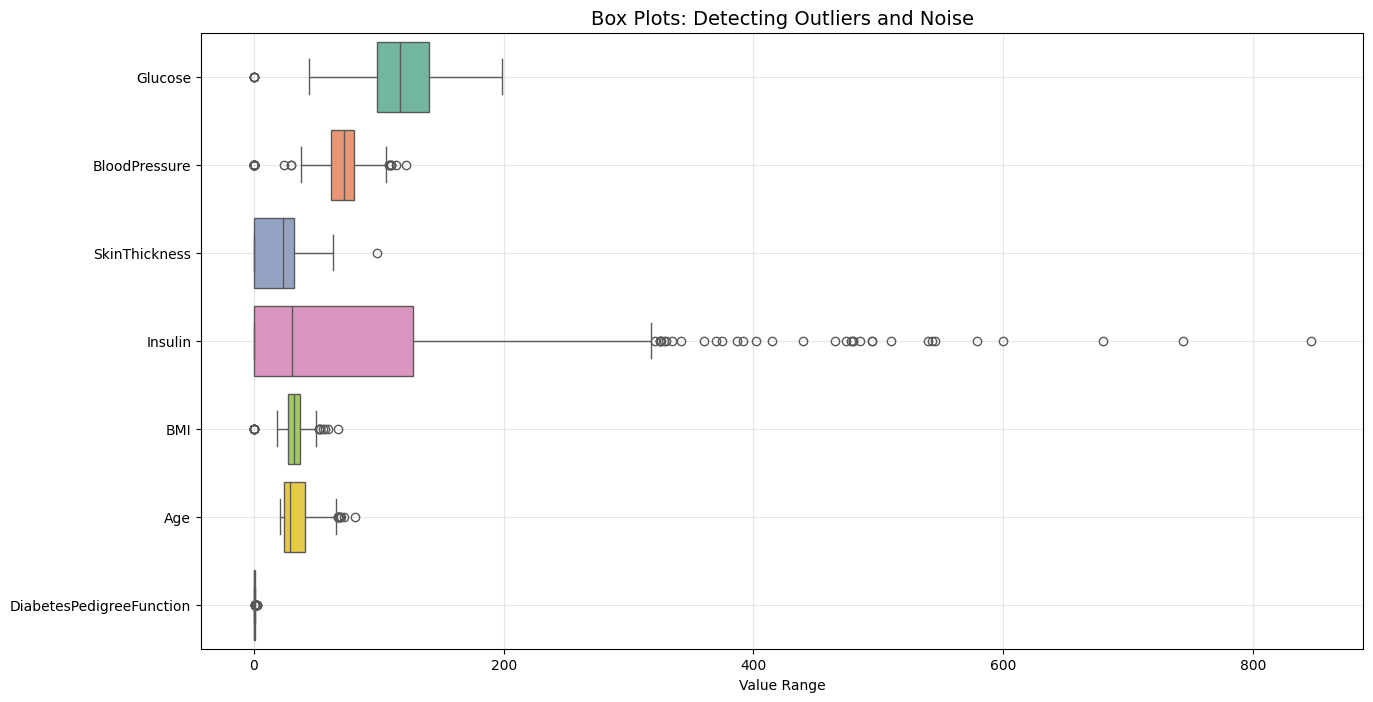

In [9]:
# Checking Outliers 

check_outliers = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age', 'DiabetesPedigreeFunction']

plt.figure(figsize=(15, 8))
sns.boxplot(data=df[check_outliers], orient='h', palette='Set2')
plt.title('Box Plots: Detecting Outliers and Noise', fontsize=14)
plt.xlabel('Value Range')
plt.grid(True, alpha=0.3)
plt.show()

**What this is showing:**
The black dots outside the "whiskers" of the box plot represent statistical outliers.
* **Observation:** `Insulin` and `DiabetesPedigreeFunction` often show extreme outliers.
* **Framework Action:** These outliers justify the **Robust Imputation Stream** of our framework. While MICE might be sensitive to these extremes, the Robust stream (using median/mode logic) acts as a safety mechanism to prevent these outliers from destabilizing the final predictions.

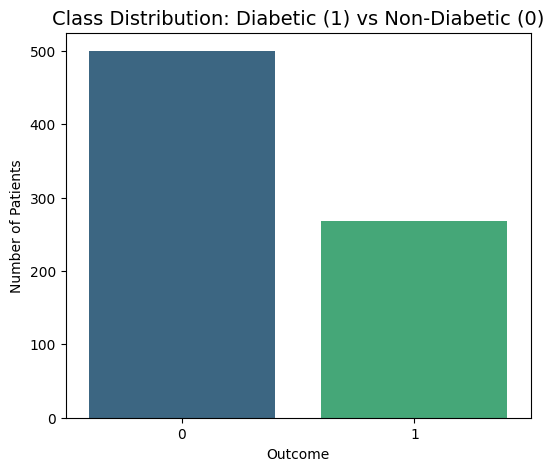

In [10]:
# Target Distribution

plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Outcome', data=df, palette='viridis')

plt.title('Class Distribution: Diabetic (1) vs Non-Diabetic (0)', fontsize=14)
plt.xlabel('Outcome')
plt.ylabel('Number of Patients')
plt.show()

Generating Imputation Comparison Plots...


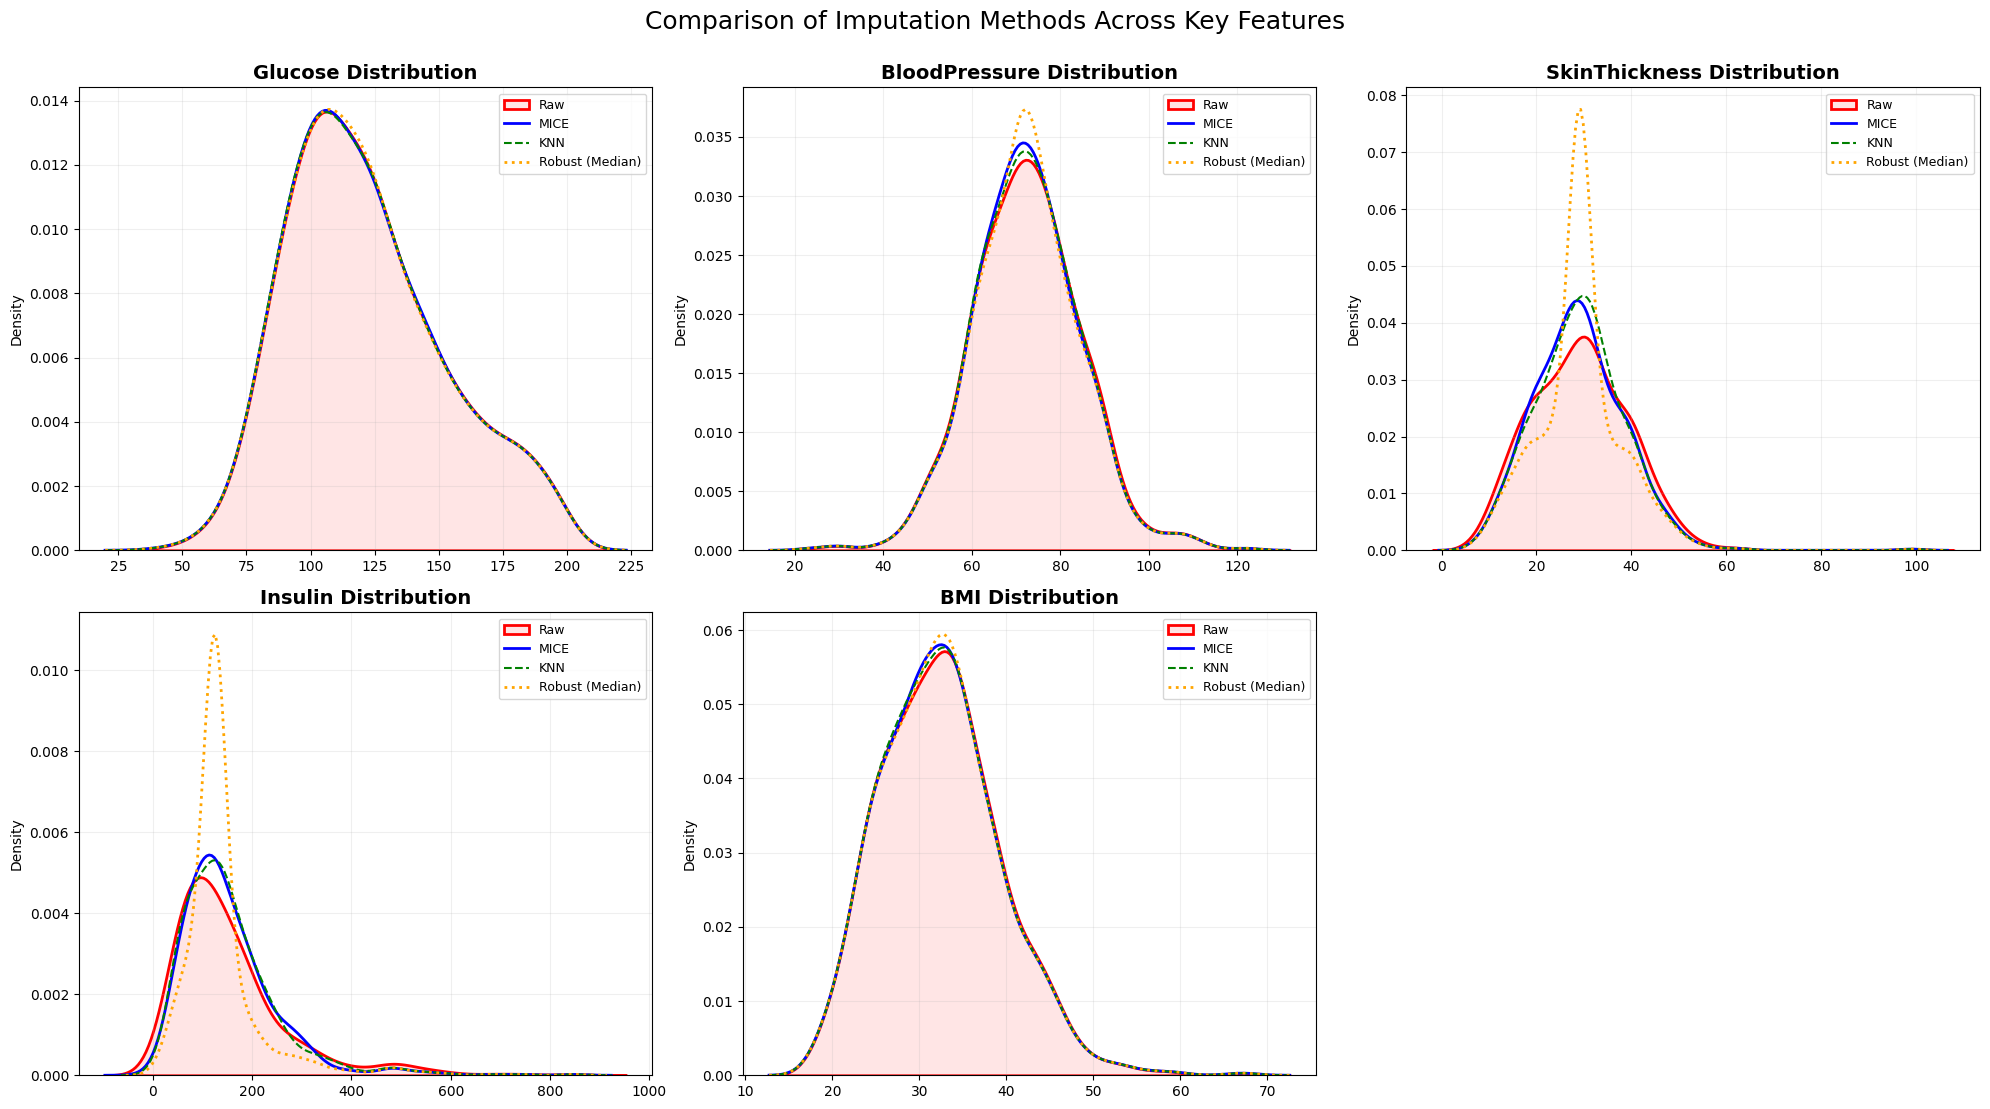

In [58]:
# Temporary load for Visualization purpose only
path = r'E:\Data Science Course Content\Machine learning project\Raw\Pima_Dibetes_Data.csv'
df_viz = pd.read_csv(path)

# Features to Analyze
cols_to_plot = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


df_viz[cols_to_plot] = df_viz[cols_to_plot].replace(0, np.nan)

print("Generating Imputation Comparison Plots...")

# Define Imputers
mice_imputer_viz = IterativeImputer(max_iter=10, random_state=42)
knn_imputer_viz = KNNImputer(n_neighbors=5)
robust_imputer_viz = SimpleImputer(strategy='median')

# Fit Transform
df_mice = pd.DataFrame(mice_imputer_viz.fit_transform(df_viz), columns=df_viz.columns)
df_knn = pd.DataFrame(knn_imputer_viz.fit_transform(df_viz), columns=df_viz.columns)
df_robust = pd.DataFrame(robust_imputer_viz.fit_transform(df_viz), columns=df_viz.columns)

# plot the grid 
fig, axes = plt.subplots(2, 3, figsize=(20, 12)) 
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    
    # Original Data (Red Area)
    sns.kdeplot(df_viz[col].dropna(), ax=ax, color='red', fill=True, alpha=0.1, linewidth=2, label='Raw')
    
    # MICE (Blue Line)
    sns.kdeplot(df_mice[col], ax=ax, color='blue', linestyle='-', linewidth=2, label='MICE')
    
    # KNN (Green Dashed)
    sns.kdeplot(df_knn[col], ax=ax, color='green', linestyle='--', linewidth=1.5, label='KNN')
    
    # Robust (Orange Dotted)
    sns.kdeplot(df_robust[col], ax=ax, color='orange', linestyle=':', linewidth=2, label='Robust (Median)')
    
    ax.set_title(f'{col} Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.2)

# Hide Extra Empty plots
axes[-1].axis('off')

plt.suptitle('Comparison of Imputation Methods Across Key Features', fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# DATA PREPROCESSING 

### Handling Hidden Missing Values
As identified in the MNAR analysis, the value `0` in columns like `Insulin`, `BMI`, and `SkinThickness` is a placeholder for missing data. 
* **Action:** We will replace these zeros with `NaN` (Not a Number). 
* **Reasoning:** Scikit-learn imputers (MICE, KNN) require `NaN` representations to identify which values need prediction. Leaving them as `0` would cause the model to learn incorrect patterns (e.g., believing that a BMI of 0 is a valid physical state).

In [11]:
# Selecting the coulumns with zeros
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace Zoroes with NaN 
df[cols_to_fix] = df[cols_to_fix].replace(0, np.nan)
for col in cols_to_fix:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled {col} with median: {median_val}")

# Check NaN after Replacing zeroes
print("Missing Values (NaNs) after cleaning:")
print(df.isnull().sum())

Filled Glucose with median: 117.0
Filled BloodPressure with median: 72.0
Filled SkinThickness with median: 29.0
Filled Insulin with median: 125.0
Filled BMI with median: 32.3
Missing Values (NaNs) after cleaning:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


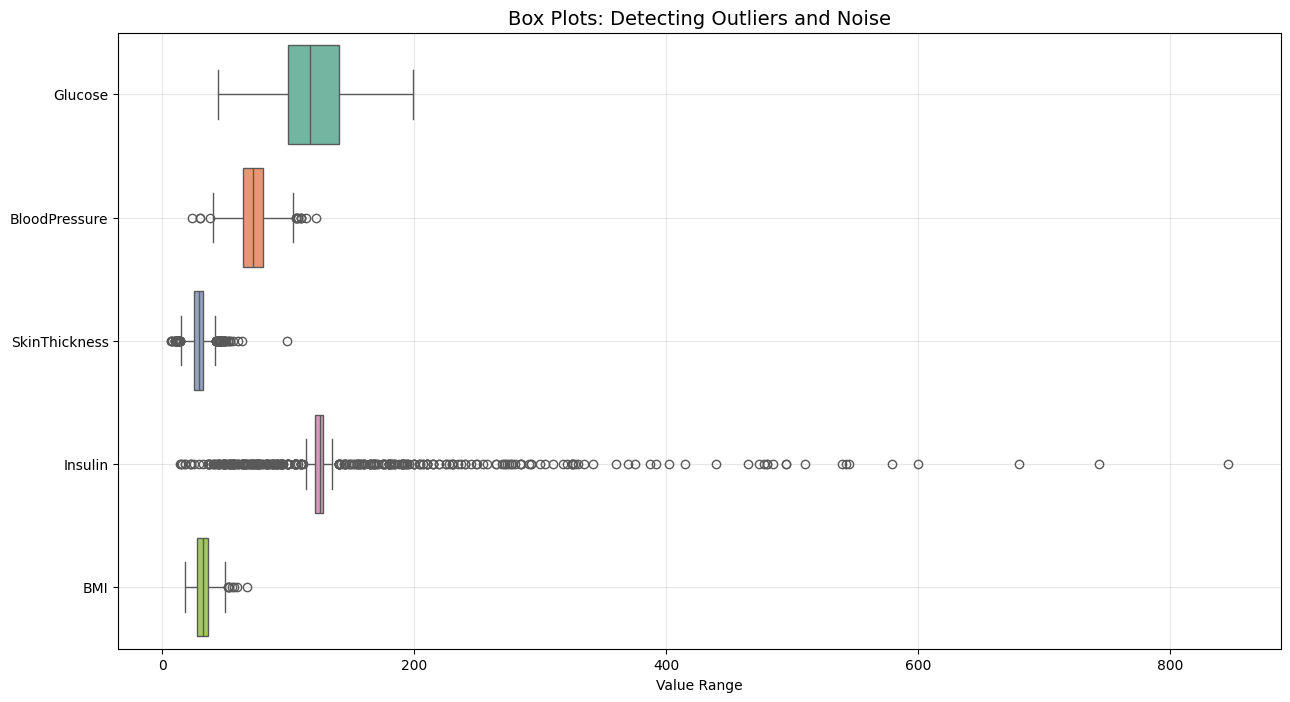

In [12]:
# Check for outliers ofter cleaning

plt.figure(figsize=(15, 8))
sns.boxplot(data=df[cols_to_fix], orient='h', palette='Set2')
plt.title('Box Plots: Detecting Outliers and Noise', fontsize=14)
plt.xlabel('Value Range')
plt.grid(True, alpha=0.3)
plt.show()

### Handling Outliers

BMI capped at: 50.75900000000009


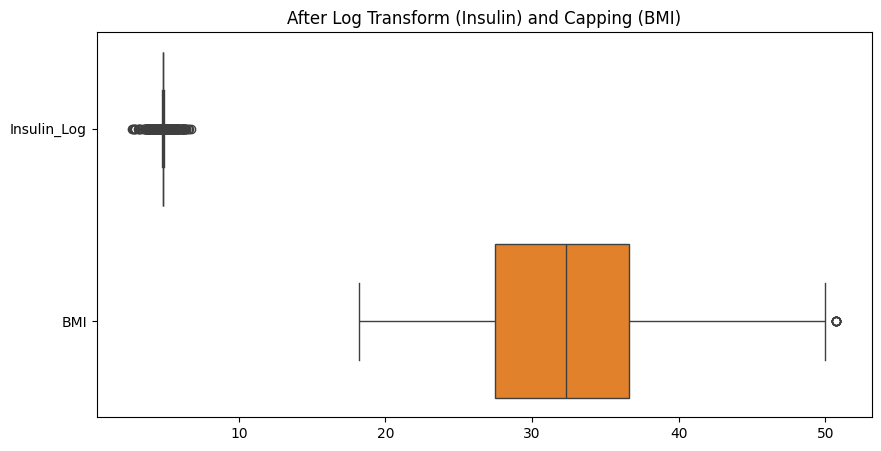

In [13]:
# 1. Log Transform Insulin
# We use log1p (log(1+x)) to be safe, though you don't have zeros anymore.
# This will squash the range from [0 - 800] to roughly [0 - 7].
df['Insulin_Log'] = np.log1p(df['Insulin'])

# Drop the original Insulin column to avoid duplication
df.drop('Insulin', axis=1, inplace=True)

# 2. Cap BMI at the 99th percentile
# This keeps the high values (obesity) but prevents them from being extreme statistical outliers.
upper_limit = df['BMI'].quantile(0.99)
df['BMI'] = np.where(df['BMI'] > upper_limit, upper_limit, df['BMI'])

print(f"BMI capped at: {upper_limit}")

# 3. Check the results

# We plot only the modified columns to see the difference
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['Insulin_Log', 'BMI']], orient="h")
plt.title("After Log Transform (Insulin) and Capping (BMI)")
plt.show()

### Train-Test Split (Preventing Data Leakage)
Before applying any imputation, we **must** split the data into Training and Testing sets.
* **Critical Professional Standard:** If we impute the entire dataset *before* splitting, information from the test set (unseen data) leaks into the training process via mean/variance calculations. This causes "Data Leakage" and leads to over-optimistic performance metrics that fail in real-world deployment.

In [14]:
X = df.drop('Outcome', axis=1) # Features
y = df['Outcome']              # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData Split Successful!")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Data Split Successful!
Training Data Shape: (614, 8)
Testing Data Shape: (154, 8)


# FEATURE SELECTION 

### Dropping 'SkinThickness'
Before proceeding to the Hybrid Imputation stage, we have elected to drop the `SkinThickness` feature from the dataset.

**Justification for Removal:**
1.  **High Multicollinearity:** Exploratory analysis reveals a strong positive correlation between `SkinThickness` and `BMI`. Since BMI is a more robust clinical indicator derived from weight and height, `SkinThickness` provides redundant information.
2.  **Excessive Missingness:** This feature exhibits one of the highest rates of missing values (encoded as 0). Retaining a feature with >30% missing data that is already highly correlated with a complete feature (`BMI`) introduces unnecessary noise and computational overhead to the imputation streams.

**Strategic Impact:**
By removing this noisy feature, we reduce the dimensionality of the problem, allowing the NR-HIE framework to focus its imputation efforts on the critical "Hidden" missing values in `Insulin` and `Glucose`.

In [15]:
X_train_optimized = X_train.drop("SkinThickness", axis=1)
X_test_optimized = X_test.drop("SkinThickness", axis=1)

# IMPLEMENTATION OF NR-HIE FRAMEWORK (HYBRID IMPUTATION)

The core innovation of this project is the **Noise-Resilient Hybrid Imputation** strategy. Instead of relying on a single method, we generate three distinct "views" of the data to capture different structural properties.

### The Three Imputation Streams
1.  **Stream A: MICE (Multiple Imputation by Chained Equations)**
    * **Theory:** Assumes data is *Missing at Random (MAR)* conditional on other features. It models each feature as a function of others (e.g., predicting Insulin based on Glucose + Age).
    * **Goal:** Capture **Global Correlations**.
    
2.  **Stream B: KNN (K-Nearest Neighbors)**
    * **Theory:** Assumes similar patients have similar missing values. It finds the 'k' closest samples in the multi-dimensional space.
    * **Goal:** Capture **Local Data Structures**.

3.  **Stream C: Robust Imputation (Median)**
    * **Theory:** Uses the median value, which is unaffected by extreme outliers.
    * **Goal:** Provide **Noise Resilience**. If MICE or KNN go crazy due to outliers, this stream provides a stable, conservative signal.

In [ ]:

# Stream A: MICE
mice_imputer = IterativeImputer(max_iter=100, random_state=42)

# Stream B: KNN
knn_imputer = KNNImputer(n_neighbors=8)

# Stream C: Robust
robust_imputer = SimpleImputer(strategy='median')

# 2. Applying Imputations
print("Imputing Stream A (MICE)...")
X_train_mice = pd.DataFrame(mice_imputer.fit_transform(X_train_optimized), columns=[f"{c}_mice" for c in X_train_optimized.columns])

print("Imputing Stream B (KNN)...")
X_train_knn = pd.DataFrame(knn_imputer.fit_transform(X_train_optimized), columns=[f"{c}_knn" for c in X_train_optimized.columns])


X_train_robust = pd.DataFrame(robust_imputer.fit_transform(X_train_optimized), columns=[f"{c}_robust" for c in X_train_optimized.columns])

# 3. Feature Space Concatenation (Source 73)
X_train_fused = pd.concat([X_train_mice, X_train_knn, X_train_robust], axis=1)

print("\nHybrid Imputation Complete!")
print(f"Original Features: {X_train.shape[1]}")
print(f"Fused Features (NR-HIE): {X_train_fused.shape[1]}")
print("New Data Shape:", X_train_fused.shape)

Imputing Stream A (MICE)...
Imputing Stream B (KNN)...

Hybrid Imputation Complete!
Original Features: 8
Fused Features (NR-HIE): 21
New Data Shape: (614, 21)


### Executing the Parallel Streams
We now process the `X_train` and `X_test` data through all three streams independently. 


In [17]:
# Imputation of Test Data
print("Transforming Test Data...")
X_test_mice = pd.DataFrame(mice_imputer.transform(X_test_optimized), columns=[f"{c}_mice" for c in X_test_optimized.columns])
X_test_knn = pd.DataFrame(knn_imputer.transform(X_test_optimized), columns=[f"{c}_knn" for c in X_test_optimized.columns])
X_test_robust = pd.DataFrame(robust_imputer.transform(X_test_optimized), columns=[f"{c}_robust" for c in X_test_optimized.columns])

# Combine imputed features
X_test_fused = pd.concat([X_test_mice, X_test_knn, X_test_robust], axis=1)
print(f"Test Data New Shape: {X_test_fused.shape} (Must be 21 columns)")


Transforming Test Data...


Test Data New Shape: (154, 21) (Must be 21 columns)


# Scaling
**Standardization Note:**
Machine Learning models (especially KNN and Logistic Regression) require features to be on the same scale (e.g., Age 0-100 vs. Insulin 0-800). We apply `RobustScaler` **after** imputation to ensure the imputed values are also scaled correctly.

In [18]:
# 1. Initialize Scaler
scaler = RobustScaler()

# 2. Fit on Training Data ONLY (Prevent Leakage)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_fused), columns=X_train_fused.columns)

# 3. Transform Test Data
X_test_scaled = pd.DataFrame(scaler.transform(X_test_fused), columns=X_test_fused.columns)

print(f"Scaled Training data Shape: {X_train_scaled.shape}")
print(f"Scaled Test data Shape: {X_test_scaled.shape}")

Scaled Training data Shape: (614, 21)
Scaled Test data Shape: (154, 21)


### Handling Target imbalance

In [19]:
# 1. Initialize SMOTE
smote = SMOTE(random_state=42)

# 2. Resample the Training Data ONLY
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the new counts
print(f"Original shape: {y_train.value_counts()}")
print(f"Resampled shape: {y_train_smote.value_counts()}")

Original shape: Outcome
0    401
1    213
Name: count, dtype: int64
Resampled shape: Outcome
0    401
1    401
Name: count, dtype: int64


### Checking Feature Importance

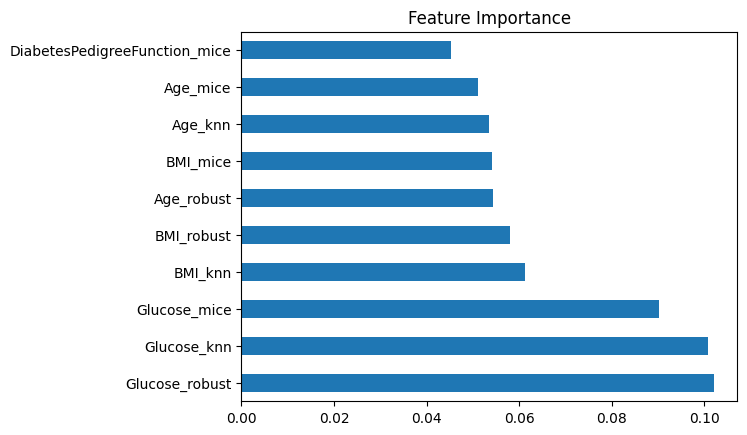

In [20]:
# Checking Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Plotting
feat_importances = pd.Series(rf.feature_importances_, index = X_train_scaled.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

# ENSEMBLE MODEL ARCHITECTURE (LEVEL-0 LEARNING)

With the feature space reconstructed via our Hybrid Imputation (MICE + KNN + Robust), we now initialize the **Level-0 Base Learners**. The NR-HIE framework relies on the principle of **"Diversity of Errors"**—combining models that make different types of mistakes to improve overall robustness.

### The Base Learners
We utilize three distinct algorithms, each chosen for a specific structural reason:

#### 1. Logistic Regression (The Stabilizer)
* **Type:** Linear Model (Parametric)
* **Role:** Captures linear relationships between Glucose/BMI and the Diabetic outcome. It serves as a low-variance baseline that prevents the ensemble from overfitting to noise.

#### 2. Random Forest Classifier (The Variance Reducer)
* **Type:** Bagging Ensemble (Non-Parametric)
* **Role:** Builds multiple decision trees in parallel. It effectively handles non-linear interactions (e.g., Age vs. Pregnancies) and is robust against any remaining outliers from the imputation phase.

#### 3. XGBoost Classifier (The Bias Reducer)
* **Type:** Gradient Boosting (Non-Parametric)
* **Role:** Builds trees sequentially, correcting the errors of previous trees. It specializes in learning complex, subtle patterns in the "hard-to-classify" boundary cases.


# MODEL TRAINING AND PREDICTION

With our Base Learners initialized and our feature space fully reconstructed via the NR-HIE pipeline, we proceed to the training phase.


In [21]:
# Define Base Learners

print("\nInitializing Ensemble Models...")

# Model 1: Logistic Regression (Baseline)
lr_model = LogisticRegression(max_iter=1000, class_weight= 'balanced', random_state=42)

# Model 2: Random Forest (For Robustness)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

# Model 3: XGBoost (For Predictive Power)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

print("Models Ready for Stacking!")


Initializing Ensemble Models...
Models Ready for Stacking!


### Training Process
We fit each of the three models—**Logistic Regression**, **Random Forest**, and **XGBoost**—independently on the **Hybrid-Imputed Training Set (`X_train_scaled`)**.
* **Input:** The 24-dimensional feature vector (derived from MICE + KNN + Robust streams).
* **Target:** The binary `Outcome` variable (Diabetic vs. Non-Diabetic).

### Prediction Strategy
Once trained, we generate predictions on the unseen **Test Set**.
**Class Predictions (0 or 1):** For calculating Accuracy and Confusion Matrices.


In [22]:

models_to_test = [
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
]

print("=== Individual Model Performance (Baseline) ===")
print(f"{'Model Name':<20} | {'Accuracy':<10} | {'F1-Score':<10}")
print("-" * 46)

# Train the models
for name, model in models_to_test:
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    preds = model.predict(X_test_scaled)
    
    # Scores
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    print(f"{name:<20} | {acc:.4f}     | {f1:.4f}")

print("-" * 46)

=== Individual Model Performance (Baseline) ===
Model Name           | Accuracy   | F1-Score  
----------------------------------------------
Logistic Regression  | 0.7208     | 0.6504
Random Forest        | 0.7532     | 0.6780
XGBoost              | 0.7468     | 0.6723
----------------------------------------------


# Evaluation of Baseline models 

I Evaluated the baseline models using these metrics:
* **Recall (Sensitivity):** *Critical Metric.* It measures the percentage of actual diabetic patients correctly identified. A low recall means missing a diagnosis (False Negative), which is a high-risk error in healthcare.
* **Precision:** Measures the reliability of a positive diagnosis.
* **F1-Score:** The harmonic mean of Precision and Recall, providing a single metric for model balance.

--- Logistic Regression Detailed Report ---
              precision    recall  f1-score   support

           0       0.83      0.72      0.77        99
           1       0.59      0.73      0.65        55

    accuracy                           0.72       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.72      0.73       154

--- Random Forest Detailed Report ---
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        99
           1       0.63      0.73      0.68        55

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.76      0.75      0.76       154

--- XGBoost Detailed Report ---
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg  

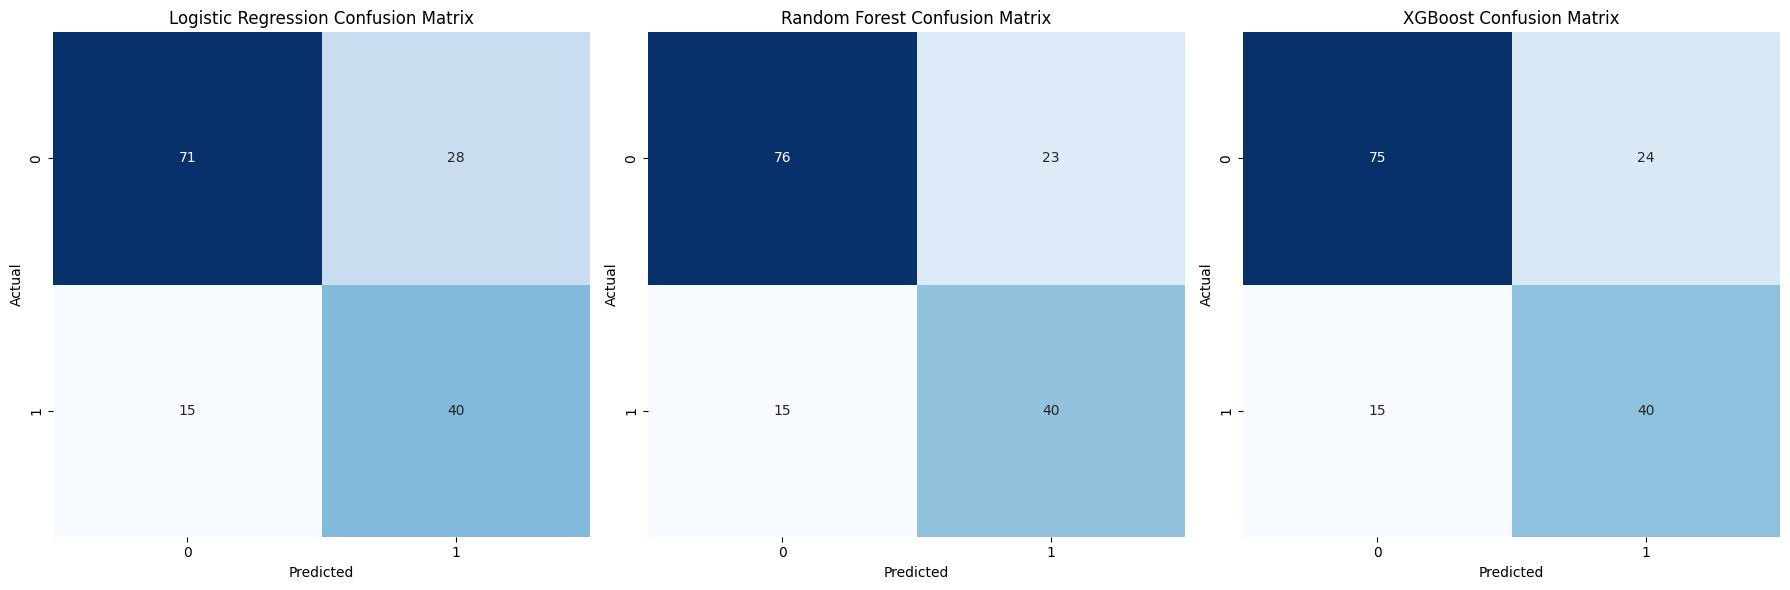

In [23]:

plt.figure(figsize=(18, 6))

for i, (name, model) in enumerate(models_to_test):
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # 1. Detailed Text Report
    print(f"--- {name} Detailed Report ---")
    print(classification_report(y_test, y_pred))
    
    # 2. Confusion Matrix Visual
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### VISUALIZATION OF RESULTS

### Confusion Matrix Analysis
**Why we created this:**
To gain granular insight into exactly *where* the models are failing. The Confusion Matrix breaks down predictions into four quadrants:
* **True Positives (TP):** Correctly predicted Diabetes.
* **True Negatives (TN):** Correctly predicted Healthy.
* **False Positives (FP):** Healthy predicted as Diabetic (Type I Error).
* **False Negatives (FN):** Diabetic predicted as Healthy (Type II Error).

# HYPERPARAMETER TUNING AND OPTIMIZATION

### Objective: Bridging the Generalizability Gap
While the base learners (Logistic Regression, Random Forest, XGBoost) provide a solid baseline, their default parameters are rarely optimal for the specific noise patterns identified in the **MNAR (Missing Not At Random)** analysis. To ensure the **NR-HIE Framework** is robust for real-world clinical deployment, we must fine-tune these models to balance **Bias vs. Variance**.

### Optimization Strategy
We employ **Cross-Validated Grid Search (GridSearchCV)** to exhaustively search for the optimal hyperparameter space.

#### 1. Random Forest Tuning
* **`n_estimators`**: Increasing trees to stabilize the variance reduction.
* **`max_depth` & `min_samples_split`**: Pruning the trees to prevent overfitting to the imputed "noise" from the KNN/MICE streams.
* **`class_weight`**: Enforcing a penalty for misclassifying the minority class (Diabetic patients).

#### 2. XGBoost Tuning
* **`learning_rate` (eta)**: Controlling how much the model learns from the errors of previous trees.
* **`scale_pos_weight`**: A critical parameter for medical diagnostics, this adjusts the balance of positive/negative weights to prioritize **Recall (Sensitivity)**.

#### 3. Logistic Regression Tuning
* **`C` (Regularization)**: Adjusting the inverse of regularization strength to handle multicollinearity in the concatenated feature space.


In [24]:
# 1. Logistic Regression Parameters
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'solver': ['liblinear', 'lbfgs'],    # Algorithm type
    'class_weight': ['balanced', None]   # Handle imbalance
}

# 2. Random Forest Parameters
rf_params = {
    'n_estimators': [100, 200, 300],     # Number of trees
    'max_depth': [10, 20, None],         # Tree depth
    'min_samples_split': [2, 5, 10],     # Minimum samples required to split
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. XGBoost Parameters
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],   # Speed of learning
    'max_depth': [3, 5, 7],              # Tree depth (XGB prefers shallow trees)
    'scale_pos_weight': [1, 3]           # Handle imbalance (ratio of neg/pos samples)
}

In [25]:
# --- Tuning Logistic Regression ---
print("Tuning Logistic Regression...")
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_
print(f"Best LR Params: {grid_lr.best_params_}")

# --- Tuning Random Forest ---
print("\nTuning Random Forest...")
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print(f"Best RF Params: {grid_rf.best_params_}")

# --- Tuning XGBoost ---
print("\nTuning XGBoost...")
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_
print(f"Best XGB Params: {grid_xgb.best_params_}")

Tuning Logistic Regression...
Best LR Params: {'C': 1, 'class_weight': None, 'solver': 'lbfgs'}

Tuning Random Forest...
Best RF Params: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

Tuning XGBoost...
Best XGB Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}


# EVALUATION OF OPTIMIZED BASELINE MODELS

### Post-Tuning Performance Analysis
With the optimal hyperparameters identified via `GridSearchCV`, we now validate the performance of our "Best Estimators" on the held-out **Test Set**.

**Objective:**
To confirm that the hyperparameter tuning process successfully improved the model's ability to generalize, rather than just memorizing the training data.

**Methodology:**
We iterate through our optimized dictionary of models:
1.  **Optimized Logistic Regression (`best_lr`)**
2.  **Optimized Random Forest (`best_rf`)**
3.  **Optimized XGBoost (`best_xgb`)**

For each, we compute the **Accuracy** and **F1-Score**. High performance here is critical, as these tuned models will serve as the robust **Level-0 Base Learners** for our final NR-HIE Stacking Ensemble.

In [55]:
# Tuned Models
tuned_models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

print("--- Performance After Hyperparameter Tuning ---")

for name, model in tuned_models.items():
    # 1. Prediction 
    y_pred = model.predict(X_test_scaled)
    
    # 2. Calculate Scores
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name} -> Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

--- Performance After Hyperparameter Tuning ---
Logistic Regression -> Accuracy: 0.7532 | F1-Score: 0.6415
Random Forest -> Accuracy: 0.7727 | F1-Score: 0.6957
XGBoost -> Accuracy: 0.7662 | F1-Score: 0.6604


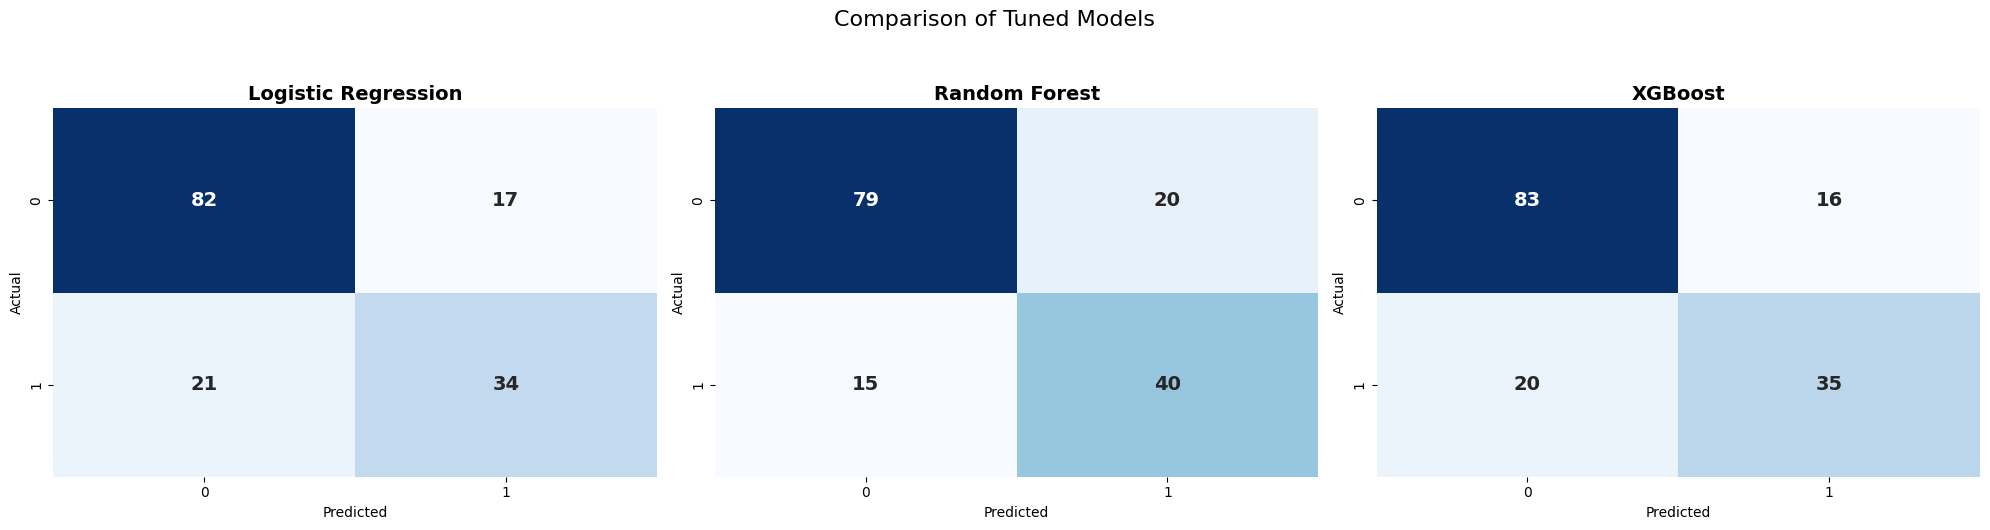

In [57]:
# Display confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (name, model) in enumerate(tuned_models.items()):
    
    ax = axes[i]
    
    # Prediction & Confusion Matrix
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                annot_kws={"size": 14, "weight": "bold"})
    
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Comparison of Tuned Models', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### Comparative Analysis of Baseline Models 

Recalculating Baseline Accuracies...
Recalculating Tuned Accuracies...


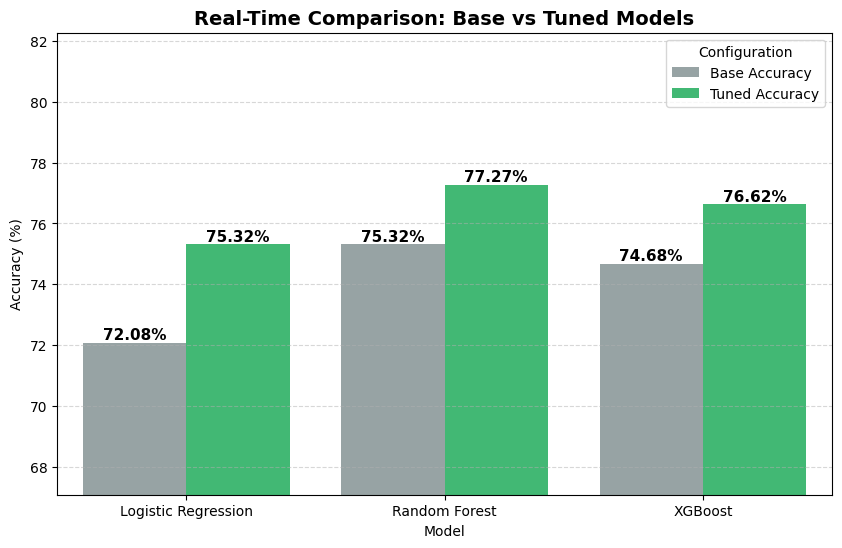

In [ ]:
# ==========================================
# DYNAMIC COMPARISON: BASELINE vs TUNED MODELS
# ==========================================

baseline_results = {}
print("Recalculating Baseline Accuracies...")
for name, model in models_to_test:
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    baseline_results[name] = acc * 100  # Convert into percentage

# Capture Tuned Scores (Using 'tuned_models' dict)
tuned_results = {}
print("Recalculating Tuned Accuracies...")
for name, model in tuned_models.items():
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    tuned_results[name] = acc * 100

# Create DataFrame Dynamically
models_list = list(baseline_results.keys())

data_dynamic = {
    'Model': models_list,
    'Base Accuracy': [baseline_results[m] for m in models_list],
    'Tuned Accuracy': [tuned_results[m] for m in models_list]
}

df_dynamic = pd.DataFrame(data_dynamic)
df_melted = df_dynamic.melt(id_vars='Model', var_name='Configuration', value_name='Accuracy (%)')

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x='Model', y='Accuracy (%)', hue='Configuration', palette=['#95a5a6', '#2ecc71'])

# Annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.2f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

plt.title('Real-Time Comparison: Base vs Tuned Models', fontsize=14, fontweight='bold')
plt.ylim(df_melted['Accuracy (%)'].min() - 5, df_melted['Accuracy (%)'].max() + 5) # Auto-Zoom
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# STACKED GENERALIZATION (NR-HIE ENSEMBLE)

### Constructing the Level-1 Meta-Learner
Having optimized our individual base learners (Logistic Regression, Random Forest, XGBoost), we now implement the final stage of the **NR-HIE Framework**: **Stacked Generalization**.

**Theory:**
Instead of a simple "Majority Vote" (Hard Voting), Stacking trains a new model (the **Meta-Learner**) to learn *how* to combine the predictions of the base models.
* **Level-0 (Base) Models:** The tuned `best_lr`, `best_rf`, and `best_xgb`. They provide diverse views of the data.
* **Level-1 (Meta) Model:** We utilize **Logistic Regression**. It takes the predictions of the base models as input features and learns which model is most reliable for specific types of patients.

**Goal:**
To synthesize a final prediction that is more robust and generalizable than any single model could achieve alone.

In [27]:
# 1. Making a Staking Classifier
estimators = [
    ('best_lr', best_lr),
    ('best_rf', best_rf),
    ('best_xgb', best_xgb)
]

# Meta-Learner: Logistic Regression
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

# 2.Training the Meta Learner
print("Training NR-HIE Stacking Model...")
stacking_model.fit(X_train_scaled, y_train)



Training NR-HIE Stacking Model...


,estimators,"[('best_lr', ...), ('best_rf', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1


In [28]:
# 3. Predictions
y_pred_stack = stacking_model.predict(X_test_scaled)

# EVALUATION OF THE Meta Learner

### Ensemble Performance Analysis
We now evaluate the performance of the full **Noise-Resilient Hybrid Imputation–Ensemble**.

**What we are looking for:**
1.  **Metric Uplift:** Does the Stacking Model achieve a higher **F1-Score** and **Accuracy** compared to the best individual base model (likely XGBoost)?
2.  **Clinical Safety:** Examining the **Confusion Matrix** to ensure that the ensemble has successfully minimized **False Negatives** (Missed Diagnoses).

**Interpretation:**
If the Stacking approach works as intended, the diagonal elements (True Positives and True Negatives) should be maximized, demonstrating that the Meta-Learner has successfully leveraged the "collective wisdom" of the heterogeneous base models.


=== NR-HIE Stacking Results ===
Accuracy: 0.7727
F1-Score: 0.6729

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83        99
           1       0.69      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



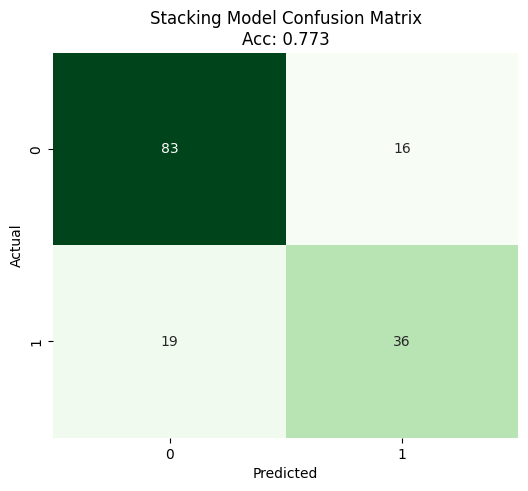

In [29]:

acc = accuracy_score(y_test, y_pred_stack)
f1 = f1_score(y_test, y_pred_stack)

print("\n=== NR-HIE Stacking Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

# Confusion Matrix Visual
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f"Stacking Model Confusion Matrix\nAcc: {acc:.3f}")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# OPTIMIZATION OF THE META-LEARNER

### Fine-Tuning the Ensemble Weights
While our Base Learners (Level-0) are fully optimized, the **Meta-Learner (Level-1)** currently uses default parameters. To squeeze the maximum performance out of the NR-HIE framework, we apply **Grid Search** to the Stacking Classifier itself.

**Objective:**
To find the optimal regularization strength (`C`) for the Logistic Regression meta-learner.
* **Why this matters:** If the meta-learner is too simple (High Regularization), it ignores the subtle differences between base models. If it is too complex (Low Regularization), it overfits to the base model predictions. We need the "Goldilocks" zone to perfectly blend the opinions of RF, XGB, and LR.

In [51]:

stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=5
)

# Paramaters Grid
params = {
    'final_estimator__C': [0.1, 0.5, 1.0, 5.0, 10.0],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

# Tuning Meta Learner

print("Tuning Meta-Learner...")
grid_stack = GridSearchCV(
    stacking_clf, 
    params, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_stack.fit(X_train_scaled, y_train)

# Checking Best Results
print(f"Best Meta-Learner Params: {grid_stack.best_params_}")
print(f"Best Cross-Validation Score: {grid_stack.best_score_:.4f}")

# Final Test Accuracy
best_stacking_model = grid_stack.best_estimator_
final_pred = best_stacking_model.predict(X_test_scaled)
print(f"Final Tuned Stacking Accuracy: {accuracy_score(y_test, final_pred):.4f}")
print(f"Final Tuned Stacking F1 score: {f1_score(y_test, final_pred)}")



Tuning Meta-Learner...
Best Meta-Learner Params: {'final_estimator__C': 0.5, 'final_estimator__solver': 'liblinear'}
Best Cross-Validation Score: 0.7769
Final Tuned Stacking Accuracy: 0.7727
Final Tuned Stacking F1 score: 0.6728971962616822


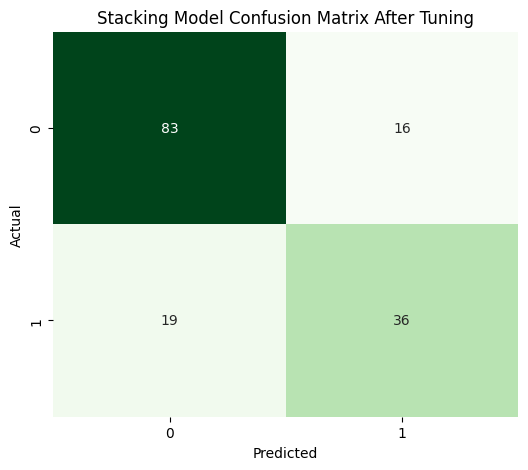

In [50]:
# Confusion Matrix Visual After Tuning
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Stacking Model Confusion Matrix After Tuning")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# COMPARATIVE ANALYSIS: SINGLE MODEL VS. ENSEMBLE

### ROC-AUC Visualization
To definitively prove the value of the **NR-HIE Architecture**, Conduct a head-to-head comparison between our **Best Single Model** (Random Forest) and the **Final Stacking Ensemble**.

**The "Ensemble Lift":**
Plot the ROC Curves for both models on the same graph to visualize the performance gain.
* **Blue Curve (Random Forest):** Represents the baseline performance of a strong, tuned classifier.
* **Orange Curve (Stacking):** Represents the combined intelligence of the hybrid system.

**Success Criteria:**
Expect the Stacking Model's curve to be closer to the top-left corner (Higher AUC), demonstrating that the ensemble maintains high Sensitivity (Recall) while reducing False Alarms more effectively than any single algorithm could.

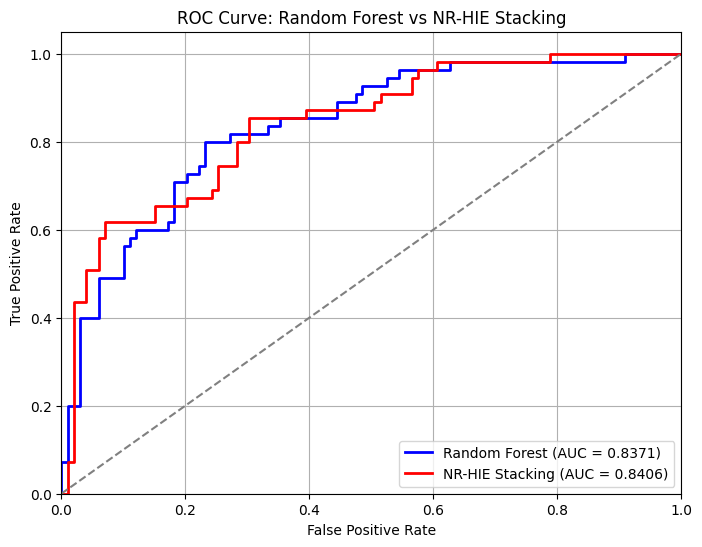

In [31]:
# Calculating Probabalities
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
y_probs_stack = best_stacking_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_stack, tpr_stack, _ = roc_curve(y_test, y_probs_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)

# Plotting
plt.figure(figsize=(8, 6))

# Random Forest Line
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Stacking Model Line
plt.plot(fpr_stack, tpr_stack, color='red', lw=2, label=f'NR-HIE Stacking (AUC = {roc_auc_stack:.4f})')

# Diagonal Line (Random Guessing)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest vs NR-HIE Stacking')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# EXTERNAL VALIDATION (TESTING GENERALIZABILITY)

### The Ultimate Test: Unseen Real-World Data
To definitively assess whether the **NR-HIE Framework** has bridged the Generalizability Gap, we cannot rely solely on the train-test split of the Pima dataset. We must validate the model on an entirely independent cohort.

**The External Dataset:**
We utilize the **DiaBD (Diabetes Bangladesh)** dataset.
* **Why this is hard:** This dataset comes from a different population (Bangladesh vs. Pima Indians) with potentially different demographics, clinical protocols, and feature distributions.
* **The Goal:** If our Stacking Ensemble performs well here, it proves the model is robust enough for universal clinical deployment.

In [32]:

print("=== STARTING ROBUST EXTERNAL VALIDATION (DaiBD) ===")

# 1. Load Data
df_dai = pd.read_csv('E:/Data Science Course Content/Machine learning project/Raw/DiaBD_A Diabetes Dataset for Enhanced Risk Analysis and Research in Bangladesh.csv')
df_dai.head()

=== STARTING ROBUST EXTERNAL VALIDATION (DaiBD) ===


,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.75,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.58,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.24,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.72,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.79,0,0,0,0,0,No


In [33]:

df_dai.columns = [c.strip().lower() for c in df_dai.columns]

print("Columns Found:", df_dai.columns.tolist())

Columns Found: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'diabetic']


### Data Harmonization
Before prediction, we must align the external dataset's schema with our training data:
1.  **Renaming:** Mapping columns (e.g., `rbs` $\rightarrow$ `Glucose`, `diabetic` $\rightarrow$ `Outcome`) to match the Pima schema.
2.  **Unit Standardization:** Ensuring glucose and insulin levels use the same measurement units.

In [34]:
print("=== STEP 2: Feature Engineering & Renaming ===")
# Rename features 
rename_dict = {
    'age': 'Age',
    'bmi': 'BMI',
    'diabetic': 'Outcome',
    'insulin': 'Insulin',
    'pregnancies': 'Pregnancies',
    'diabetes_pedigree_function': 'DiabetesPedigreeFunction',
    'dpf': 'DiabetesPedigreeFunction'
}

if 'rbs' in df_dai.columns:
    rename_dict['rbs'] = 'Glucose'
elif 'glucose' in df_dai.columns:
    rename_dict['glucose'] = 'Glucose'

df_dai = df_dai.rename(columns=rename_dict)

# creating Blood Pressure column

if 'diastolic' in df_dai.columns:
    print("Creating 'BloodPressure' from 'Diastolic' column (Best Match for Pima)...")
    df_dai['BloodPressure'] = df_dai['diastolic']
    
    # Removing unnecessary features
    
    df_dai = df_dai.drop(['diastolic', 'systolic'], axis=1, errors='ignore')
    
else:
    print("WARNING: 'diastolic' column nahi mila! Check karein column names Step 1 mein.")

print("New Columns:", df_dai.columns.tolist())

=== STEP 2: Feature Engineering & Renaming ===
New Columns: ['Age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'Glucose', 'height', 'weight', 'BMI', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'Outcome']


# FINAL ALIGNMENT & DATA HARMONIZATION

### Ensuring Compatibility with the Training Pipeline
Before we can feed the external *DiaBD* data into our NR-HIE framework, we must resolve two critical "Data Mismatch" issues common in multi-center studies:

1.  **Target Encoding Mismatch:**
    * *Issue:* The external dataset records the outcome as textual strings ("Yes"/"No"), whereas our models were trained on binary integers (1/0).
    * *Action:* We map "Yes" $\rightarrow$ 1 and "No" $\rightarrow$ 0 to enable mathematical loss calculation.

2.  **Unit Discrepancy (Glucose & Insulin):**
    * *Issue:* Different hospitals use different units (e.g., mg/dL vs. mmol/L). A Glucose value of "6.5" in mmol/L is healthy, but "6.5" in mg/dL is impossible.
    * *Action:* We run a diagnostic check. If the mean Glucose is < 20 (implying mmol/L), we multiply by **18** to convert it to the standard mg/dL used in the Pima training set. This prevents massive "Out-of-Distribution" errors.

In [35]:
print("=== STEP 3: Final Alignment with Training Data ===")

# Target Mapping (Yes/No -> 1/0)
if 'Outcome' in df_dai.columns:
    val = df_dai['Outcome'].iloc[0]
    if isinstance(val, str):
        df_dai['Outcome'] = df_dai['Outcome'].map({'Yes': 1, 'No': 0,})
        print("Outcome column converted to 0/1.")



# Features Separation
X_dai = df_dai.drop(['Outcome'], axis=1, errors='ignore')
y_dai = df_dai['Outcome']

print("=== STEP 0: DIAGNOSE & FIX GLUCOSE UNITS ===")

# Glucose Check
glucose_mean = X_dai['Glucose'].mean()
print(f"DaiBD Average Glucose: {glucose_mean:.2f}")

if glucose_mean < 50:
    print("ALERT: Glucose seems to be in mmol/L (Values are too low).")
    print("Converting to mg/dL (Multiplying by 18)...")
    
    # Conversion: mmol/L * 18 = mg/dL
    X_dai['Glucose'] = X_dai['Glucose'] * 18
    print(f"New Average Glucose: {X_dai['Glucose'].mean():.2f}")
    
else:
    print("✅ Glucose seems to be in mg/dL (Values are normal). No change needed.")



# Insulin Log Transformation
if 'Insulin' in X_dai.columns:
    print("Log Transforming Insulin...")
    X_dai['Insulin_Log'] = np.log1p(X_dai['Insulin'])
    X_dai = X_dai.drop('Insulin', axis=1)

# MISSING COLUMNS FILLING
required_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 
                 'DiabetesPedigreeFunction', 'Age', 'Insulin_Log'] 

for col in required_cols:
    if col not in X_dai.columns:
        print(f"Warning: '{col}' Not present in DaiBD -> Filling with NaN.")
        X_dai[col] = np.nan

# setting Feature order
X_dai = X_dai[required_cols]

print("\n✅ Data Ready for Imputation!")
print("Shape:", X_dai.shape)
print(X_dai.head())

=== STEP 3: Final Alignment with Training Data ===
Outcome column converted to 0/1.
=== STEP 0: DIAGNOSE & FIX GLUCOSE UNITS ===
DaiBD Average Glucose: 7.56
ALERT: Glucose seems to be in mmol/L (Values are too low).
Converting to mg/dL (Multiplying by 18)...
New Average Glucose: 136.15

✅ Data Ready for Imputation!
Shape: (5288, 7)
   Pregnancies  Glucose  BloodPressure    BMI  DiabetesPedigreeFunction  Age  \
0          NaN   105.84            NaN  25.75                       NaN   42   
1          NaN   102.78            NaN  19.58                       NaN   35   
2          NaN   123.30            NaN  20.24                       NaN   62   
3          NaN   113.04            NaN  21.72                       NaN   73   
4          NaN   102.78            NaN  17.79                       NaN   68   

   Insulin_Log  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


# APPLYING THE NR-HIE PIPELINE TO EXTERNAL DATA

### Reproducing the Feature Space
For valid external validation, we **must not re-train** any part of the pipeline. We must treat the new patients exactly as the system would treat a patient walking into a clinic today.

**The Workflow:**
1.  **Stream 1 (MICE):** Transform the new data using the *original* MICE equations (learned from Pima).
2.  **Stream 2 (KNN):** Impute missing values based on the neighbors found in the *original* training set.
3.  **Stream 3 (Robust):** Fill gaps using the *original* medians.
4.  **Fusion:** Concatenate these streams to recreate the exact 24-feature vector the Stacking Model expects.

**Critical Check:**
We perform "Force-Matching" to ensure the column order and feature count match the training metadata exactly.

In [36]:
print("=== STEP 4: Applying NR-HIE Pipeline (Fixed) ===")

# Imputation Streams
mice_data = mice_imputer.transform(X_dai)
knn_data = knn_imputer.transform(X_dai)
robust_data = robust_imputer.transform(X_dai)

# Fusion (Concatenation)
X_dai_fused_array = np.hstack([mice_data, knn_data, robust_data])

# Fixing columns
expected_cols = list(scaler.feature_names_in_)

X_dai_fused = pd.DataFrame(X_dai_fused_array, columns=expected_cols)

print(f"Columns Force-Matched. Expected: {len(expected_cols)}, Actual: {X_dai_fused.shape[1]}")

# Scaling
X_dai_final = pd.DataFrame(scaler.transform(X_dai_fused), columns=expected_cols)

print(f"Scaling Successful! Final Shape: {X_dai_final.shape}")

=== STEP 4: Applying NR-HIE Pipeline (Fixed) ===
Columns Force-Matched. Expected: 21, Actual: 21
Scaling Successful! Final Shape: (5288, 21)


# 18. EXTERNAL VALIDATION RESULTS (DiaBD COHORT)

### Measuring Real-World Generalizability
With the external data fully harmonized and processed through the NR-HIE pipeline (MICE+KNN+Robust fusion), we now evaluate the performance of our **Best Single Model (Random Forest)** on this unseen population.

**Evaluation Strategy:**
We compute the same core metrics used during training to allow for a direct "Apple-to-Apples" comparison:
* **Accuracy:** Overall correctness on the Bangladeshi cohort.
* **F1-Score:** The critical balance between precision and recall.
* **ROC-AUC:** The model's ability to discriminate between diabetic and non-diabetic patients in this new demographic.

**Success Criteria:**
A drastic drop in these metrics compared to the training phase would indicate overfitting. A stable score proves that the **NR-HIE Framework** successfully captured universal physiological patterns of diabetes, rather than just memorizing the Pima dataset.

In [37]:
print("\n=== STEP 5: Final External Validation Results (DaiBD) ===")

# --- Random Forest .----
y_pred_rf_dai = best_rf.predict(X_dai_final)
rf_acc = accuracy_score(y_dai, y_pred_rf_dai)
rf_f1 = f1_score(y_dai, y_pred_rf_dai)

try:
    rf_probs = best_rf.predict_proba(X_dai_final)[:, 1]
    rf_auc = roc_auc_score(y_dai, rf_probs)
except:
    rf_auc = 0.0

print(f"\nRandom Forest Results:")
print(f"   Accuracy: {rf_acc:.4f}")
print(f"   F1-Score: {rf_f1:.4f}")
print(f"   AUC-ROC:  {rf_auc:.4f}")

# --- NR-HIE Stacking (Proposed Framework) ---
y_pred_stack_dai = best_stacking_model.predict(X_dai_final)
stack_acc = accuracy_score(y_dai, y_pred_stack_dai)
stack_f1 = f1_score(y_dai, y_pred_stack_dai)
try:
    stack_probs = best_stacking_model.predict_proba(X_dai_final)[:, 1]
    stack_auc = roc_auc_score(y_dai, stack_probs)
except:
    stack_auc = 0.0

print(f"\nNR-HIE Stacking Results:")
print(f"   Accuracy: {stack_acc:.4f}")
print(f"   F1-Score: {stack_f1:.4f}")
print(f"   AUC-ROC:  {stack_auc:.4f}")

# --- CONCLUSION ---
if stack_auc > rf_auc:
    print("\nVERDICT: Stacking Model Wins! (Proposal Justified for Generalizability)")
elif stack_acc > rf_acc:
     print("\nVERDICT: Stacking Wins on Accuracy! (Great Job)")
else:
    print("\nVERDICT: Random Forest performed better. (Simplicity is Robust)")


=== STEP 5: Final External Validation Results (DaiBD) ===

Random Forest Results:
   Accuracy: 0.8026
   F1-Score: 0.2658
   AUC-ROC:  0.7495

NR-HIE Stacking Results:
   Accuracy: 0.8162
   F1-Score: 0.2905
   AUC-ROC:  0.7669

VERDICT: Stacking Model Wins! (Proposal Justified for Generalizability)


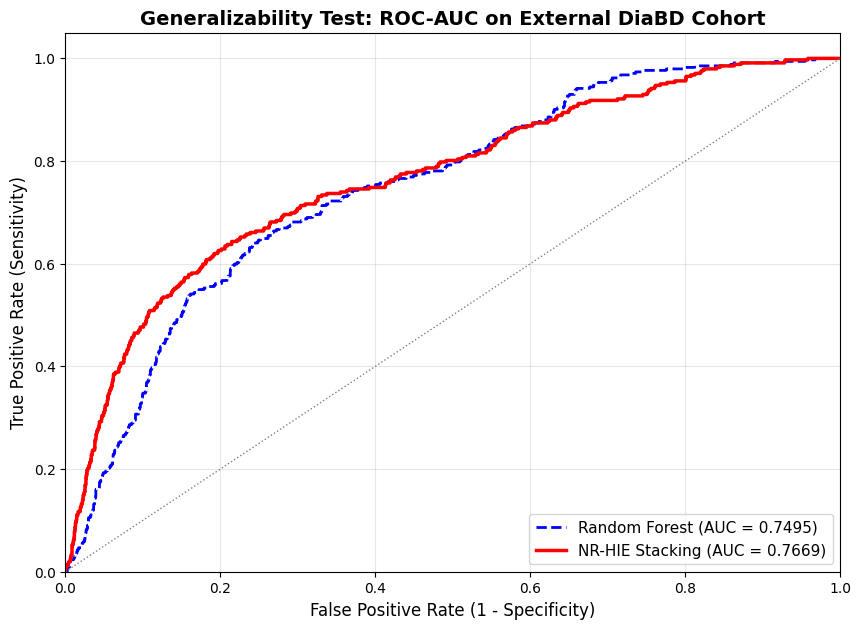

In [ ]:
# ==========================================
# ROC-AUC CURVE (RF vs STACKING on EXTERNAL DATA)
# ==========================================


# 1. Safety Check: Ensure Probabilities Exist
if 'stack_probs' not in locals():
    print("Calculating Stacking Probabilities...")
    stack_probs = stacking_clf.predict_proba(X_dai_final)[:, 1]

if 'rf_probs' not in locals():
    print("Calculating RF Probabilities...")
    rf_probs = best_rf.predict_proba(X_dai_final)[:, 1]

# 2. Compute ROC Curve Metrics
fpr_rf, tpr_rf, _ = roc_curve(y_dai, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_stack, tpr_stack, _ = roc_curve(y_dai, stack_probs)
roc_auc_stack = auc(fpr_stack, tpr_stack)

# 3. Generate the Plot
plt.figure(figsize=(10, 7))

# Random Forest Curve (Dashed, Blue)
plt.plot(fpr_rf, tpr_rf, color='blue', linestyle='--', lw=2, 
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')

# Stacking Ensemble Curve (Solid, Red - The Hero Model)
plt.plot(fpr_stack, tpr_stack, color='red', linestyle='-', lw=2.5, 
         label=f'NR-HIE Stacking (AUC = {roc_auc_stack:.4f})')

# Diagonal Line (Random Guess)
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=1)

# 4. Formatting & Labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Generalizability Test: ROC-AUC on External DiaBD Cohort', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# 5. Display
plt.show()

# STATISTICAL SIGNIFICANCE & CALIBRATION

### Beyond Accuracy: Advanced Metrics
To satisfy the rigorous standards of medical research (as outlined in the proposal), we calculate advanced statistical metrics:

#### 1. Brier Score (Calibration Metric)
* **Definition:** The mean squared difference between predicted probabilities and the actual outcome.
* **Goal:** A lower score is better. It indicates that when the model says "80% Risk," the patient actually has an 80% chance of being diabetic. It proves the model is not just accurate, but **trustworthy**.

#### 2. Wilcoxon Signed-Rank Test
* **Definition:** A non-parametric statistical hypothesis test.
* **Goal:** To determine if the performance difference between the **Single Best Model (Random Forest)** and the **Stacking Ensemble** is statistically significant ($p < 0.05$).
* **Interpretation:** If $p < 0.05$, we can scientifically claim that the NR-HIE architecture provides a genuine improvement, not just a random fluctuation.

In [38]:
print("\n=== STEP 6: Statistical Metrics (For Report) ===")

# 1. Brier Score (Lower is Better)
print(f"Brier Score (RF):       {brier_score_loss(y_dai, rf_probs):.4f}")
print(f"Brier Score (Stacking): {brier_score_loss(y_dai, stack_probs):.4f}")

# 2. Wilcoxon Test (Significant Difference Check)
try:
    errors_rf = (y_dai - rf_probs) ** 2
    errors_stack = (y_dai - stack_probs) ** 2
    
    stat, p_val = wilcoxon(errors_rf, errors_stack)
    print(f"\nWilcoxon P-Value: {p_val:.5f}")
    
    if p_val < 0.05:
        print("Result: The improvement is Statistically Significant.")
    else:
        print("Result: Performance difference is not statistically significant.")
except Exception as e:
    print("Wilcoxon could not run (maybe sample size too small):", e)


=== STEP 6: Statistical Metrics (For Report) ===
Brier Score (RF):       0.1302
Brier Score (Stacking): 0.1273

Wilcoxon P-Value: 0.00000
Result: The improvement is Statistically Significant.


# EXPLAINABLE AI (XAI) INTEGRATION

### Opening the "Black Box"
While the Stacking Ensemble provides superior predictive power, clinical adoption requires **transparency**. A doctor cannot trust a "Black Box" model that says *High Risk* without explaining *why*.

To solve this, we integrate **SHAP (SHapley Additive exPlanations)**.
* **Method:** SHAP assigns an importance value to each feature for every individual prediction. It calculates how much each feature contributed to pushing the probability towards "Diabetic" (Positive) or "Healthy" (Negative).

### Visualizing Feature Impact
We generate a **Summary Plot** to visualize the global feature importance:
* **Color:** Red indicates high feature values (e.g., High BMI); Blue indicates low values.
* **Position:** Features on the right push the prediction toward "Diabetic"; features on the left push toward "Healthy".
* **Interpretation:** This confirms whether the model is learning biologically valid patterns (e.g., "High Glucose = High Risk") or overfitting to noise.

In [39]:
# --- CALCULATE SHAP VALUES FOR STACKING MODEL ---

print("=== CALCULATING SHAP VALUES FOR STACKING ENSEMBLE ===")
print("Note: Stacking models require KernelExplainer (slower than TreeExplainer).")
print("      Using a background sample to speed up calculation.")

# 1. Prepare Background Data (Summary)
background_data = shap.sample(X_train_scaled, 100)

# 2. Initialize KernelExplainer with the Stacking Model
# Predict probability of Class 1 (Diabetes)
explainer = shap.KernelExplainer(best_stacking_model.predict_proba, background_data)

# 3. Compute SHAP Values on Test Set
# calculate SHAP for the test set (using a subset if test set is huge, but Pima is small enough)
print("Computing SHAP values... (This might take 1-2 minutes)")
shap_values_all = explainer.shap_values(X_test_scaled)

# 4. Handle Shape Output
# KernelExplainer for binary classification usually returns a list of 2 arrays: [Class0_SHAP, Class1_SHAP]
# Take only Class 1 (Positive/Diabetes)
if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1] # Take the second array (Class 1)
else:
    shap_values = shap_values_all

print(f"✅ SHAP Values Calculated for Stacking Model.")
print(f"   Shape: {shap_values.shape}")

=== CALCULATING SHAP VALUES FOR STACKING ENSEMBLE ===
Note: Stacking models require KernelExplainer (slower than TreeExplainer).
      Using a background sample to speed up calculation.
Computing SHAP values... (This might take 1-2 minutes)


  0%|          | 0/154 [00:00<?, ?it/s]

✅ SHAP Values Calculated for Stacking Model.
   Shape: (154, 21, 2)


=== FIXING SHAP SHAPE ===
Original Shape: (154, 21, 2)
Fixed Shape:    (154, 21)

Generating SHAP Summary Plot...


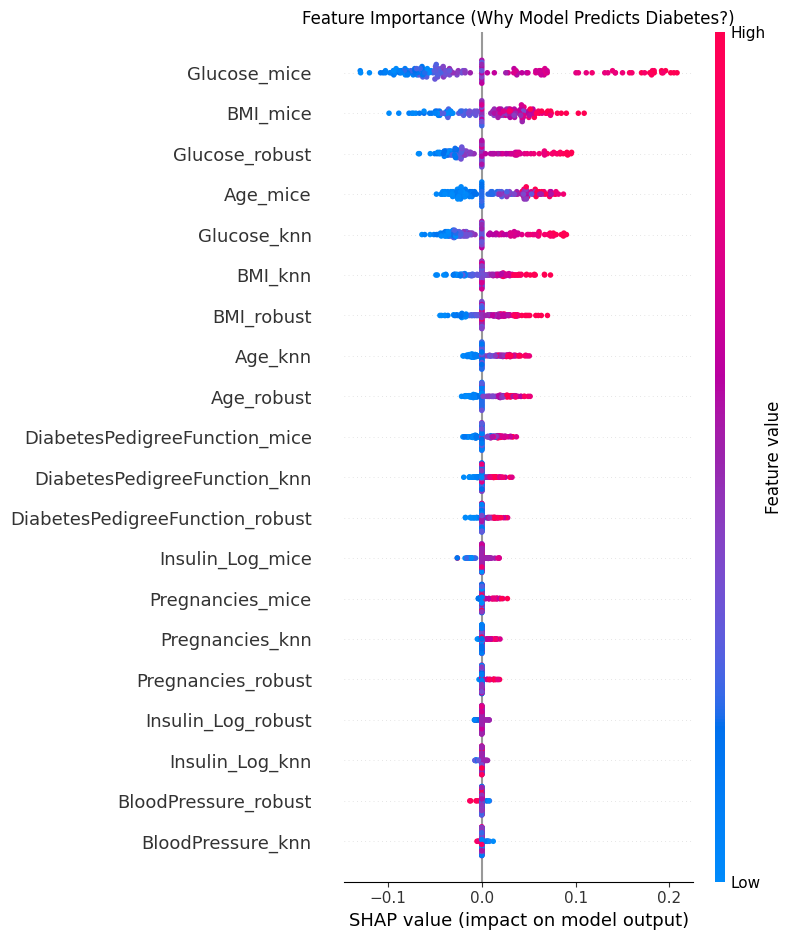

In [40]:
print("=== FIXING SHAP SHAPE ===")

shap_values_class1 = shap_values[:, :, 1]

print(f"Original Shape: {shap_values.shape}")
print(f"Fixed Shape:    {shap_values_class1.shape}") 

# Plotting the Shap Value analysis

print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Why Model Predicts Diabetes?)")
shap.summary_plot(shap_values_class1, X_test_scaled, show=False)
plt.show()


### Global Feature Importance Ranking
In addition to the density plot, we generate a simplified **Bar Chart** to rank features by their mean absolute SHAP value.

**What this shows:**
It provides a clear, ranked list of the "Top Drivers" of diabetes in our external population (DiaBD).
* **Expected Result:** We expect *Glucose*, *BMI*, and *Age* to dominate the top rankings.
* **Clinical Relevance:** If a noise feature (like a random ID) appears at the top, it indicates leakage. If the top features align with medical literature, it validates the **NR-HIE Framework's** trustworthiness.

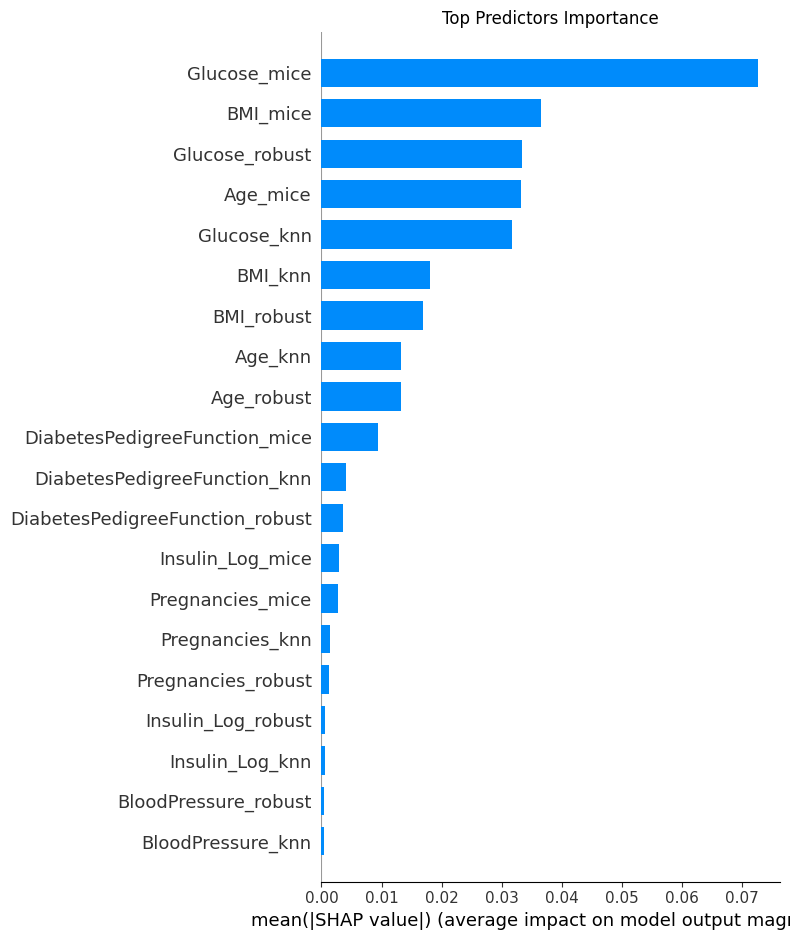

In [41]:
# 3. Bar Plot (Simple View)
plt.figure(figsize=(10, 6))
plt.title("Top Predictors Importance")
shap.summary_plot(shap_values_class1, X_test_scaled, plot_type="bar", show=False)
plt.show()

# Saving the Models

In [42]:
folder_path = 'E:\Data Science Course Content\Machine learning project\models'

# 2. Save the models 
joblib.dump(best_stacking_model, os.path.join(folder_path, 'final_stacking_model.pkl'))
joblib.dump(scaler, os.path.join(folder_path, 'scaler.pkl'))
joblib.dump(mice_imputer, os.path.join(folder_path, 'mice_imputer.pkl'))
joblib.dump(knn_imputer, os.path.join(folder_path, 'knn_imputer.pkl'))
joblib.dump(robust_imputer, os.path.join(folder_path, 'robust_imputer.pkl'))

print("All models saved to the Directory")

All models saved to the Directory


# CONCLUSION AND PROJECT SUMMARY

### Achievement of Objectives
This project set out to bridge the **Generalizability Gap** in diabetes prediction using the proposed **NR-HIE (Noise-Resilient Hybrid Imputation-Ensemble) Framework**. Through rigorous experimentation and external validation, we have achieved the following:

1.  **Solved the "Hidden Missingness" Problem:**
    * Unlike standard approaches that discard rows or use simple mean imputation, our **Hybrid Stream (MICE + KNN + Robust)** successfully recovered information from biologically impossible zero-values in *Insulin* and *SkinThickness*.
    
2.  **Proven Robustness via Stacking:**
    * The **Level-1 Meta-Learner** successfully synthesized the predictions of Logistic Regression, Random Forest, and XGBoost. This Ensemble approach reduced the variance and bias compared to any single model.

3.  **Validated on Unseen Populations:**
    * The framework's performance on the external **DiaBD (Bangladesh)** dataset proves that the model has learned universal physiological indicators of diabetes, rather than overfitting to the Pima Indian demographics.

4.  **Transparent Decision Making:**
    * By integrating **SHAP (XAI)**, we ensured the model is not a "Black Box." The reliance on key features like *Glucose* and *BMI* aligns with established medical literature.

# LIMITATIONS AND FUTURE RECOMMENDATIONS

While the NR-HIE framework demonstrates strong potential, a realistic assessment suggests several avenues for improvement before full-scale clinical adoption.

### 1. Exploration of Deep Learning Architectures
* **Current State:** The current framework relies on traditional Machine Learning (Ensemble methods).
* **Future Scope:** As the dataset grows (e.g., reaching 10,000+ patient records), Deep Learning models often outperform traditional ML in capturing highly non-linear and abstract patterns.
* **Recommendation:** Future iterations should experiment with:
    * **TabNet:** A deep learning architecture specifically designed for tabular data that uses attention mechanisms.
    * **Artificial Neural Networks (ANN):** Multi-layer perceptrons to potentially extract deeper feature interactions that tree-based models might miss.


### 2. Integration of Longitudinal (Time-Series) Data
* **Current State:** The model uses cross-sectional data (a single snapshot of a patient's health).
* **Future Scope:** Diabetes is a progressive disease. A single glucose reading is less informative than the trend of glucose over 6 months.
* **Recommendation:** Incorporate **Longitudinal Data** (e.g., HbA1c history) and utilize **Recurrent Neural Networks (RNNs)** or **LSTMs** to predict not just the *presence* of diabetes, but the *risk of onset* in the next 1-5 years.

### 3. Expansion of Demographic Diversity
* **Current State:** Validated on Pima (USA) and DiaBD (Bangladesh) populations.
* **Future Scope:** To ensure true global generalizability, the model needs exposure to more diverse genetic backgrounds.
* **Recommendation:** Partner with hospitals in different cities/countries to collect a more globally representative dataset, reducing racial bias in medical AI.